# Multi-tissue classification colorectal cancer

**Table of Contents**                                                                      
Step1: Environment Setup                                                                          
Step2: Data Loading and Preparation                                                                      
Step3: Analyzing Class Distribution                                                          
Step4: Data Augmentation for Minority Classes                                                            
Step5: Splitting the Dataset                                                                                     
Step6: Preparing Data Generators                                                             
Step7: Building the Model                                                                                       
Step8: Compiling the Model with Class Weights                                                  
Step9: Implementing Learning Rate Scheduling and Early Stopping                                      
Step10: Training the Model                                                             
Step11: Evaluating the Model                                                                   
Step12: Conclusion and Next Steps                                                           



In [36]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


**Step: 1 Environment Setup**

In [1]:
# Data manipulation and analysis
import os 
import numpy as np
import pandas as pd
from glob import glob

# Image processing
from PIL import Image

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt

**Step 2: Loading Data**


In [2]:
# Assuming the dataset is in a folder named 'dataset'
data_dir = '/kaggle/input/No_Norm'

# Get class names from subdirectory names
classes = sorted([d.name for d in os.scandir(data_dir) if d.is_dir()])
print("Classes:", classes)


# Initialize lists to hold file paths and labels
image_paths = []
image_labels = []

# Map class names to numerical labels
class_to_label = {class_name: idx for idx, class_name in enumerate(classes)}
print("Class to label mapping:", class_to_label)

# Loop through each class directory and collect file paths
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    # Get all image file paths in the class directory
    image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith('.png')]
    # Append file paths and labels
    image_paths.extend(image_files)
    image_labels.extend([class_to_label[class_name]] * len(image_files))
    #print(f"Processing {len(image_files)} images for class '{class_name}'")

print(f"Total images found: {len(image_paths)}")

Classes: ['01_TUM', '02_MUSC_STROMA', '03_LYM', '04_DEBRIS_MUCUS', '05_NORM', '06_ADI']
Class to label mapping: {'01_TUM': 0, '02_MUSC_STROMA': 1, '03_LYM': 2, '04_DEBRIS_MUCUS': 3, '05_NORM': 4, '06_ADI': 5}
Total images found: 5984


**3. Analyzing Class Distribution**

Class counts before augmentation:
 class_name
02_MUSC_STROMA     2875
05_NORM            2388
04_DEBRIS_MUCUS     485
01_TUM              103
03_LYM               72
06_ADI               61
Name: count, dtype: int64


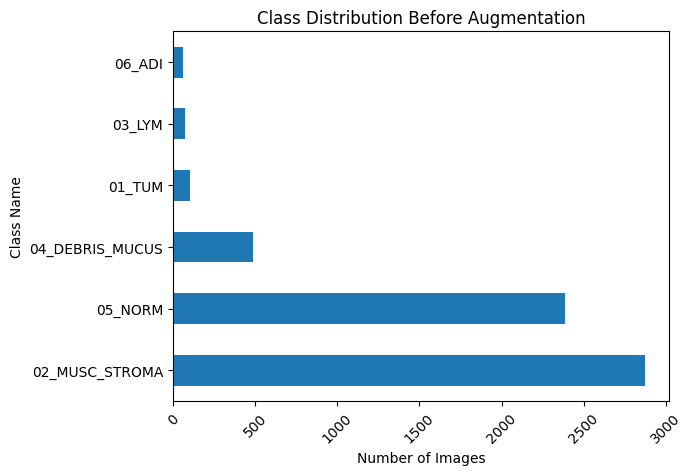

In [3]:
# Create a DataFrame to aid in analysis
df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

# Map numerical labels to class names
label_to_class = {v: k for k, v in class_to_label.items()}
df['class_name'] = df['label'].map(label_to_class)

# Display class counts
class_counts = df['class_name'].value_counts()
print("Class counts before augmentation:\n", class_counts)

# Plot class distribution
class_counts.plot(kind='barh')
plt.title('Class Distribution Before Augmentation')
plt.xlabel('Number of Images')
plt.ylabel('Class Name')
plt.xticks(rotation=45)
plt.show() 

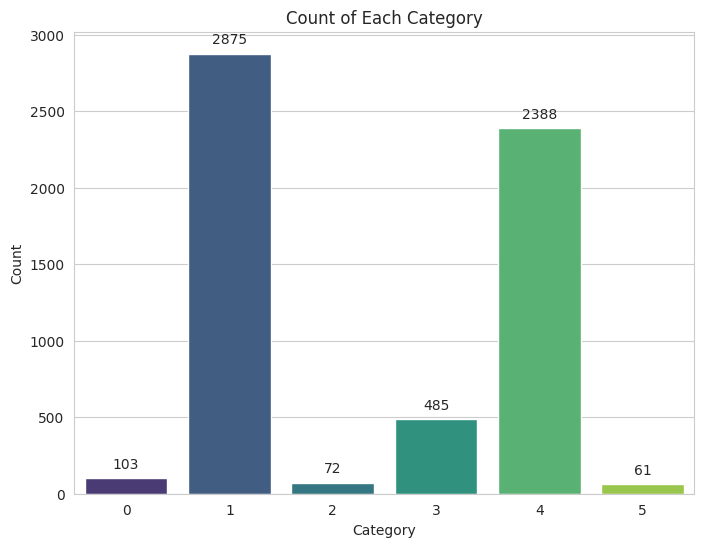

In [5]:
import seaborn as sns
     

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.countplot(data=df, x='label', palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.title("Count of Each Category")
plt.xlabel("Category")
plt.ylabel("Count")

plt.show()
     


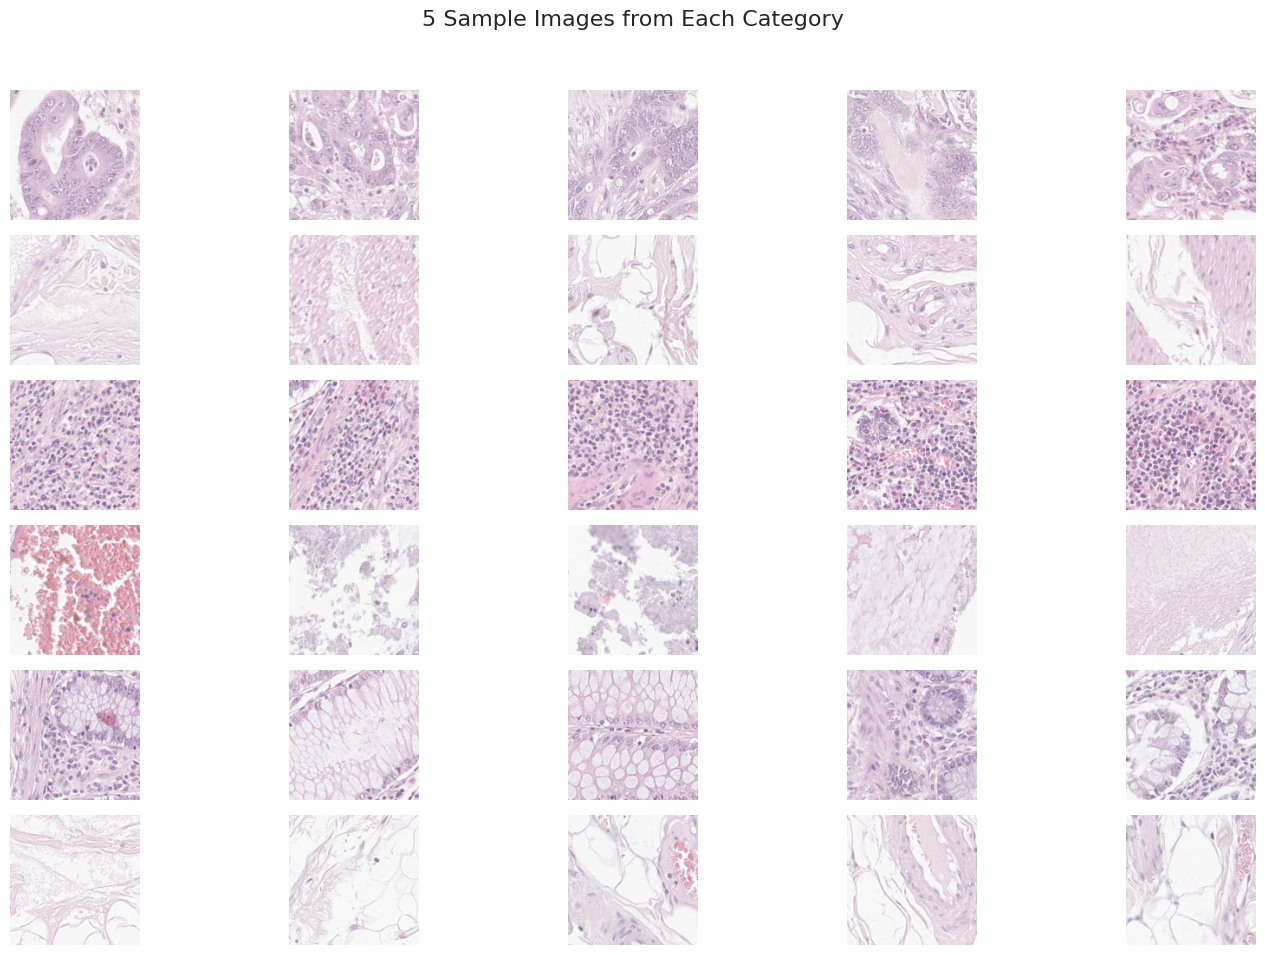

In [8]:
import cv2
     

num_images = 5

fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 10))
fig.suptitle("5 Sample Images from Each Category", fontsize=16)

for i, category in enumerate(classes):

    sample_images = df[df['class_name'] == category].sample(num_images, random_state=42)

    for j, image_path in enumerate(sample_images['image_path']):

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(category, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
     


**4. Data Augmentation for Minority Classes**


In [ ]:
# Define data augmentation transformations
def balanced_data_generator(df, batch_size, target_size, datagen):
    '''
    A generator that yields batches of images and labels, balancing classes by oversampling minority classes.
    '''
    # Get the class counts
    class_counts = df['label'].value_counts()
    max_count = class_counts.max()
    class_indices = {label: df[df['label'] == label].index for label in class_counts.index}

    while True:
        batch_paths = []
        batch_labels = []

        # Oversample minority classes
        for label, indices in class_indices.items():
            num_samples = max_count - len(indices)
            if num_samples > 0:
                extra_indices = np.random.choice(indices, size=num_samples, replace=True)
                indices = indices.union(extra_indices)

            # Shuffle indices
            indices = np.random.permutation(indices)
            batch_paths.extend(df.loc[indices, 'image_path'].tolist())
            batch_labels.extend(df.loc[indices, 'label'].tolist())

        # Combine and shuffle
        combined = list(zip(batch_paths, batch_labels))
        np.random.shuffle(combined)
        batch_paths, batch_labels = zip(*combined)

        # Yield batches
        for i in range(0, len(batch_paths), batch_size):
            batch_end = min(i + batch_size, len(batch_paths))
            batch_images = []
            batch_labels_one_hot = []

            for j in range(i, batch_end):
                # Load and preprocess the image
                img = Image.open(batch_paths[j]).convert('RGB')
                img = img.resize(target_size)
                img_array = np.array(img)
                batch_images.append(img_array)
                batch_labels_one_hot.append(to_categorical(batch_labels[j], num_classes=len(classes)))

            # Convert lists to arrays
            X_batch = np.array(batch_images)
            y_batch = np.array(batch_labels_one_hot)

            # Apply real-time data augmentation
            augmented_iterator = datagen.flow(X_batch, y_batch, batch_size=batch_size, shuffle=False)
            X_batch_augmented, y_batch_augmented = next(augmented_iterator)

            # Normalize
            X_batch_augmented = X_batch_augmented / 255.0

            yield X_batch_augmented, y_batch_augmented

**Step 5: Split the Dataset**


In [9]:
# Split into training and temp (validation + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Split temp into validation and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 4787
Validation set size: 598
Test set size: 599


**6. Preparing Data Generators**


In [13]:
# Parameters
batch_size = 16
target_size = (150, 150)  # VGG input size
num_classes = len(classes)
channels = 3
img_shape = (target_size[0], target_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='class_name',
    target_size=target_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='class_name',
    target_size=target_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='class_name',
    target_size=target_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 4787 validated image filenames belonging to 6 classes.
Found 598 validated image filenames belonging to 6 classes.
Found 599 validated image filenames belonging to 6 classes.


6.1. Training Data Generator


In [14]:
# Calculate steps per epoch
#steps_per_epoch = len(train_df) * 2 // batch_size  # Oversampling will effectively double the data

steps_per_epoch = (train_df['label'].value_counts().max() * num_classes) // batch_size


In [13]:
# Validation data preparation
def prepare_dataset(df):
    images = []
    labels = []

    for idx, row in df.iterrows():
        img = Image.open(row['image_path']).convert('RGB')
        img = img.resize(target_size)
        #img_array = np.array(img)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        #img_array = tf.expand_dims(img_array, 0)
        images.append(img_array)
        labels.append(row['label'])

    X = np.array(images) / 255.0
    y = to_categorical(labels, num_classes=len(classes))
    return X, y

# Prepare validation and test datasets
X_val, y_val = prepare_dataset(val_df)
X_test, y_test = prepare_dataset(test_df)

print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Validation set shape: (598, 150, 150, 3), (598, 6)
Test set shape: (599, 150, 150, 3), (599, 6)


**9. Building and Configuring the VGG Model**

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention
from tensorflow.keras.optimizers import Adam

def create_vgg16_modified_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = VGG16(weights='imagenet', input_tensor=inputs, include_top=False)

    for layer in base_model.layers[:-4]:
        layer.trainable = False

    x = base_model.output

    attention_output = MultiHeadAttention(num_heads=8, key_dim=x.shape[-1])(x, x)
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(6, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    return model

input_shape = img_shape
cnn_modified_model = create_vgg16_modified_model(input_shape)



cnn_modified_model.compile(optimizer=Adam(learning_rate=0.0001),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 150, 150, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 150, 150, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 75, 75, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 75, 75, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 75, 75, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 37, 37, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 37, 37, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 37, 37, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 37, 37, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 18, 18, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 18, 18, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 18, 18, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 18, 18, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 9, 9, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 9, 9, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 9, 9, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 23,513,670 (89.70 MB)

 Trainable params: 15,877,382 (60.57 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

In [16]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    #verbose=0
)

callbacks = [early_stopping, reduce_lr]

Step 7: Cross-validating model        


In [18]:
# Train the model
'''history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    #class_weight=class_weights,
    callbacks=callbacks
)'''
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = cnn_modified_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=30,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 70s 183ms/step - accuracy: 0.7595 - loss: 0.8020 - val_accuracy: 0.8094 - val_loss: 0.6738
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.8840 - loss: 0.3621 - val_accuracy: 0.9348 - val_loss: 0.1808
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.8971 - loss: 0.2971 - val_accuracy: 0.8930 - val_loss: 0.3217
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.9240 - loss: 0.2269 - val_accuracy: 0.9448 - val_loss: 0.1707
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.9451 - loss: 0.1857 - val_accuracy: 0.8746 - val_loss: 0.5898
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.9510 - loss: 0.1463 - val_accuracy: 0.9097 - val_loss: 0.2975
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.9555 - loss: 0.1355 - val_accuracy: 0.9130 - val_loss: 0.3075
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.9665 - loss: 0.1060 - val_accura

Step 8: Testing model            


In [21]:
# Evaluate the model on the test set
test_steps = len(test_df) // batch_size
test_loss, test_accuracy = cnn_modified_model.evaluate(test_gen_new, steps=test_steps)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%") 

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9518 - loss: 0.1334
Test Accuracy: 93.41%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

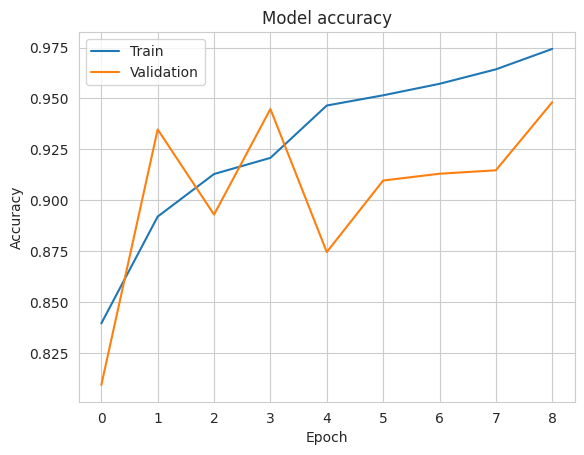

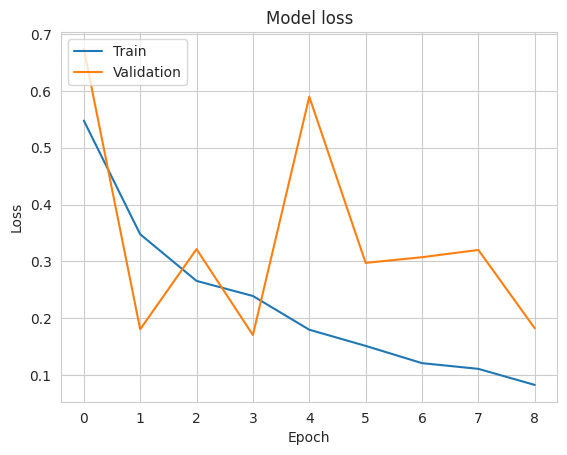

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()